<a href="https://colab.research.google.com/github/moyeed/Gender_And_Age_Detection/blob/main/Age_Gender_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **AGE AND GENDER CLASSIFICATION WITH CONVOLUTIONAL NEURAL NETWORKS**

## **Developers**:
> ### 1) Mohammed Abdul Moyeed(Z-1912165)
> ### 2) Omer Bin Ali Bajubair(Z-1905006)

## **Description**: This project creates two convolutional neural networks from scratch, one of which classifies the person based on Gender(Male or Female), whereas the other one classifies the person based on Age within 8 classes('0-2','4-6','8-13' ,'15-20','25-32', '38-43','48-53','60+')



# Importing requird Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from PIL import Image
import torchvision.transforms as transforms
from sklearn.metrics import confusion_matrix
from torch.utils.data import Dataset, DataLoader
from skimage import io

# Downloading the data from github repo by cloning it.

In [ ]:
!git clone https://github.com/omer1997/DATASET.git

fatal: destination path 'DATASET' already exists and is not an empty directory.


# Reading and merging the downloaded data.

In [ ]:
fold_0_url="https://raw.githubusercontent.com/omer1997/DATASET/main/AdienceBenchmarkGenderAndAgeClassification/fold_0_data.txt"
fold_1_url="https://raw.githubusercontent.com/omer1997/DATASET/main/AdienceBenchmarkGenderAndAgeClassification/fold_1_data.txt"
fold_2_url="https://raw.githubusercontent.com/omer1997/DATASET/main/AdienceBenchmarkGenderAndAgeClassification/fold_2_data.txt"
fold_3_url="https://raw.githubusercontent.com/omer1997/DATASET/main/AdienceBenchmarkGenderAndAgeClassification/fold_3_data.txt"
fold_4_url="https://raw.githubusercontent.com/omer1997/DATASET/main/AdienceBenchmarkGenderAndAgeClassification/fold_4_data.txt"
fold_0_data=pd.read_csv(fold_0_url,sep = "\t")
fold_1_data=pd.read_csv(fold_1_url,sep = "\t")
fold_2_data=pd.read_csv(fold_2_url,sep = "\t")
fold_3_data=pd.read_csv(fold_3_url,sep = "\t")
fold_4_data=pd.read_csv(fold_4_url,sep = "\t")
total_fold_data = pd.concat([fold_0_data, fold_1_data, fold_2_data, fold_3_data,fold_4_data], ignore_index=True)
print(' The shape of fold data 0 is : ' , fold_0_data.shape)
print(' The shape of fold data 1 is : ' , fold_1_data.shape)
print(' The shape of fold data 2 is : ' , fold_2_data.shape)
print(' The shape of fold data 3 is : ' , fold_3_data.shape)
print(' The shape of fold data 4 is : ' , fold_4_data.shape)
print(' The shape of TOTAL DATA  is : ' , total_fold_data.shape)

 The shape of fold data 0 is :  (4484, 12)
 The shape of fold data 1 is :  (3730, 12)
 The shape of fold data 2 is :  (3894, 12)
 The shape of fold data 3 is :  (3446, 12)
 The shape of fold data 4 is :  (3816, 12)
 The shape of TOTAL DATA  is :  (19370, 12)


# add image locations in the merged dataset 

In [ ]:
df = total_fold_data[['age', 'gender', 'x', 'y', 'dx', 'dy']].copy()
img_path = []
for row in total_fold_data.iterrows():
    #print(row)
    path = "/content/DATASET/AdienceBenchmarkGenderAndAgeClassification/faces/"+row[1].user_id+"/coarse_tilt_aligned_face."+str(row[1].face_id)+"."+row[1].original_image
    #print(path)
    img_path.append(path)

df['img_path'] = img_path
# display(df)
# df['img_path'][1]

# mapping different ages to following 8 classes
{
    '0-2',
    '4-6',
    '8-13',
    '15-20',
    '25-32',
    '38-43',
    '48-53',
    '60+'
}

In [ ]:
age_mapping = [('(0, 2)', '0-2'), ('2', '0-2'), ('3', '0-2'), ('(4, 6)', '4-6'), ('(8, 12)', '8-13'), ('13', '8-13'), ('22', '15-20'), ('(8, 23)','15-20'), ('23', '25-32'), ('(15, 20)', '15-20'), ('(25, 32)', '25-32'), ('(27, 32)', '25-32'), ('32', '25-32'), ('34', '25-32'), ('29', '25-32'), ('(38, 42)', '38-43'), ('35', '38-43'), ('36', '38-43'), ('42', '48-53'), ('45', '38-43'), ('(38, 43)', '38-43'), ('(38, 42)', '38-43'), ('(38, 48)', '48-53'), ('46', '48-53'), ('(48, 53)', '48-53'), ('55', '48-53'), ('56', '48-53'), ('(60, 100)', '60+'), ('57', '60+'), ('58', '60+')]

age_mapping_dict = {each[0]: each[1] for each in age_mapping}
drop_labels = []
for idx, each in enumerate(df.age):
    if each == 'None':
        drop_labels.append(idx)
    else:
        df.age.loc[idx] = age_mapping_dict[each]

        
#drop none values in age        
df = df.drop(labels=drop_labels, axis=0) #droped None values
#df.age.value_counts(dropna=False)


#drop none gender values(u)  
df = df.dropna()
unbiased_data = df[df.gender != 'u'].copy()
#unbiased_data.info()

# print(unbiased_data ['img_path'][1])
# unbiased_data.head(2)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [ ]:
#labeling gender
gender_to_label_map = {
    'f' : 0,
    'm' : 1
}

#labeling age
age_to_label_map = {
    '0-2'  :0,
    '4-6'  :1,
    '8-13' :2,
    '15-20':3,
    '25-32':4,
    '38-43':5,
    '48-53':6,
    '60+'  :7
}

label_to_age_map = {value: key for key, value in age_to_label_map.items()}
label_to_gender_map = {value: key for key, value in gender_to_label_map.items()}
#change age and gender to labels
unbiased_data['age'] = unbiased_data['age'].apply(lambda age: age_to_label_map[age])
unbiased_data['gender'] = unbiased_data['gender'].apply(lambda g: gender_to_label_map[g])
unbiased_data.reset_index(inplace=True)

# print(unbiased_data['img_path'][1])
# unbiased_data.head(2)


# visualize one image with Labels

16786
/content/DATASET/AdienceBenchmarkGenderAndAgeClassification/faces/100346410@N05/coarse_tilt_aligned_face.2070.11854635725_a940b71ae6_o.jpg


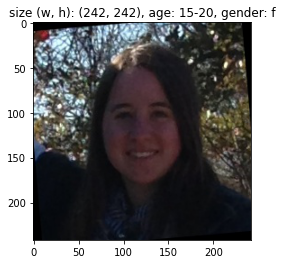

In [ ]:
#to plot image
def show_image(img_filename, age, gender):
    img = Image.open(img_filename)
    print(img_filename)
    plt.imshow(img)
    plt.title(f'size (w, h): {img.size}, age: {age}, gender: {gender}')
    plt.show()
    
idx = np.random.randint(unbiased_data.shape[0])
print(idx)
fname = unbiased_data['img_path'][idx]
age = label_to_age_map[unbiased_data['age'][idx]]
gender = label_to_gender_map[unbiased_data['gender'][idx]]
show_image(fname, age, gender)

# defining required functions for Convolutional models template and supporting functions

In [ ]:

class FaceDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, labels, data, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.labels = labels
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        label = torch.tensor(int(self.labels.iloc[idx]))
        img = self.data[idx]

        if self.transform:
            transformed_img = self.transform(img)
        img = transformed_img
        return (img,label)

class Conv_Net(nn.Module):
  '''initialize the model \n  loss_func(optional):defaults to F.cross_entropy,\n regularization = "L2" '''
  def __init__(self, loss_func = F.cross_entropy,activation_func = F.relu, regularization = "L2"):
    super(Conv_Net,self).__init__()
    self.conv1 = nn.Conv2d(3, 6, 5)
    self.conv2 = nn.Conv2d(6, 16, 5)
    self.pool = nn.MaxPool2d(2,2)
    # after calculating the size based on above convolutional layers the shape here will be [batches, chanels = 16, featres = [5,5]]
    self.fc1 = nn.Linear(16*5*5,120)
    self.fc2 = nn.Linear(120,84)
    self.fc3 = nn.Linear(84,10)
    self.activation_func = activation_func;
    self.loss_func = loss_func
    self.regularization = regularization
  
  def forward(self,x):
    
    '''This function define the forward flow of the neural network.'''
    # initializing convolutional layer
    forward_flow = self.activation_func(self.conv1(x))
    forward_flow = self.pool(forward_flow)
    forward_flow = self.activation_func(self.conv2(forward_flow))
    forward_flow = self.pool(forward_flow)
    # the first parameter is the batch size, which pytorch automatically configures and the flatten size is calculated again based on the formula.
    forward_flow = forward_flow.view(-1, 16*5*5)
    # fully connected network is started here
    forward_flow = self.activation_func(self.fc1(forward_flow))
    forward_flow = self.activation_func(self.fc2(forward_flow))
    forward_flow = self.fc3(forward_flow)
    return forward_flow

  def fit(self, train_data, val_data,epochs = 100, opt_func = torch.optim.SGD, learning_rate = 0.001,weight_decay = 0.1,weight_decay_l1= 1,moment = 0,betas = None,classes=['m','f']):
    '''This function runs for given epochs and trains the model based on the parameters given 
    \n L2 regularization is done based on the weight decay parameter in the optimizer, 
    for ADAM pytorch documentation says that it uses weight decay to find L2 reg. seperately '''
    history = []
    #Add parameters based on type of optimizer.
    if(betas != None):
      optimizer = opt_func(self.parameters(), learning_rate, betas = betas, weight_decay = weight_decay)
    else:
      optimizer = opt_func(self.parameters(), learning_rate, momentum = moment, weight_decay = weight_decay)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_data:
          loss = self.training_step(batch)
          #L1 regularization, the lambda, hyper parameter is taken from weight_decay parameter.
          if(self.regularization.lower() == "l1"):
            l1_crit = nn.L1Loss(size_average=False)
            reg_loss = 0
            for param in model.parameters():
                reg_loss += l1_crit(param,target=torch.zeros_like(param))

            loss += weight_decay_l1 * reg_loss

          loss.backward()
          optimizer.step()
          optimizer.zero_grad()
        # Validation phase
        result = self.evaluate(val_data)
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))
        history.append(result)
    self.show_confusion_matrix(train_data = training_data,val_data = val_data,classes=classes)
    return history

  def training_step(self,batch):
    ''' This function does a forward step and calculates the loss for each batch.'''
    imgs,labels = batch
    preds_with_curr_weights = self(imgs)
    loss = self.loss_func(preds_with_curr_weights,labels)
    return loss

  def evaluate(self, val_data):
    '''This function calculates the validation accuracy of whole data and returns it.'''
    outputs = [self.validation_step(batch) for batch in val_data]
    return self.validation_epoch_end(outputs)

  def validation_step(self, batch):
    '''this function calculates the validation accuracy of each batch'''
    images, labels = batch 
    out = self(images)                    
    loss = F.cross_entropy(out, labels)
    # self.add_class_details(out, labels,test_data = False)   
    acc = self.accuracy(out, labels)           
    return {'val_loss': loss.detach(), 'val_acc': acc}

  def validation_epoch_end(self, outputs):
    '''This function combines the losses and accuracy of all batches and send as one for all data'''
    batch_losses = [x['val_loss'] for x in outputs]
    epoch_loss = torch.stack(batch_losses).mean()   
    batch_accs = [x['val_acc'] for x in outputs]
    epoch_acc = torch.stack(batch_accs).mean()      
    return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

  def show_confusion_matrix(self,train_data= None,val_data =None,test_data =None,classes=['m','f']):
    ''' This function calculates the confusion matrix for given data '''
    if(train_data !=None):
      predicted = []
      actual = []
      for images,labels in train_data:
        _, preds = torch.max(self(images), dim=1)
        predicted.extend(preds.cpu())
        actual.extend(labels.cpu())
      print("The Training confusion matrix is..\n")
      conf_mat = confusion_matrix(actual,predicted)
      self.print_conf_mat(conf_mat,classes=classes)

    if(val_data !=None):
      predicted = []
      actual = []
      for images,labels in val_data:
        _, preds = torch.max(self(images), dim=1)
        predicted.extend(preds.cpu())
        actual.extend(labels.cpu())
      print("The validation confusion matrix is..\n")
      conf_mat = confusion_matrix(actual,predicted)
      self.print_conf_mat(conf_mat,classes=classes)
      print("\n")
    
    if(test_data !=None):
      predicted = []
      actual = []
      for images,labels in test_data:
        _, preds = torch.max(self(images), dim=1)
        predicted.extend(preds.cpu())
        actual.extend(labels.cpu())
      print("The test confusion matrix is..\n")
      conf_mat = confusion_matrix(actual,predicted)
      self.print_conf_mat(conf_mat,classes=classes)
      print("\n")

  def print_conf_mat(self,conf_mat,classes=['m','f']):
    ''' This function formats the confusion matrix and displays it. '''
    #classes = ['plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck']
    print("       ",end = "  ")
    for each_class in classes:
      print(f'{each_class:7s}  ',end = " ")

    print("\n")
    for row in range(len(conf_mat)):
      print(f'{classes[row]:5s}', end = "   ")
      for column in range(len(conf_mat[0])):
        print(f'{ (conf_mat[row][column]/np.sum(conf_mat[row]))*100:5.2f} %', end = "   ")
      print("\n")
    print("\n")

  def accuracy(self,outputs, labels):
    '''calculates the accuracy of the model.'''
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))
#----------------------------------------------end of Neural Network class ---------------------------------

class DeviceDataLoader():
    '''This class wraps a dataloader to move data to a device'''
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

#-------------------------------------------end of DeviceDataLoader class ------------------------------------


def load_data(X_train,y_train,X_test,y_test,batch_size = 256,val_size = 2000, normalize = True, augument_data = True):
  '''This function will load the cifar-10 dataset from pytorch. '''
  # based on the parameter, the data is being normalized to check what might be the difference if we donot normalize it.
  torch.manual_seed(17)
  if(normalize):
    transform = transforms.Compose(
        [
         transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    train_transform = transforms.Compose(
        [
         transforms.ToTensor(),
        #  transforms.RandomResizedCrop(224),
         transforms.RandomHorizontalFlip(p=0.5),
         transforms.RandomVerticalFlip(p=0.5),
        #  transforms.RandomGrayscale(p=0.3),
        #  transforms.RandomPerspective(p=0.5),
        #  transforms.RandomRotation((-360,360)),
        #  transforms.RandomInvert(p=0.3),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
  else:
    transform = transforms.Compose(
        [transforms.ToTensor()])
    train_transform = transforms.Compose(
        [
        transforms.ToTensor(),
        transforms.RandomHorizontalFlip(p=0.5),
         transforms.RandomVerticalFlip(p=0.5),
        #  transforms.RandomGrayscale(p=0.3),
        #  transforms.RandomPerspective(p=0.5),
        #  transforms.RandomRotation((-360,360)),
        #  transforms.RandomInvert(p=0.3),
         ])
  
  
 # train_set = torchvision.datasets.CIFAR10(root='./data', train=True,                                  
                                          #   download=True, transform=train_transform if augument_data else transform)
  train_set= FaceDataset(y_train,X_train,train_transform if augument_data else transform)
  torch.manual_seed(43)
  train_size = len(train_set) - val_size
  train_ds, val_ds = torch.utils.data.random_split(train_set, [train_size, val_size])
  
  train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size,
                                            shuffle=True, num_workers=2)
  
  val_loader = torch.utils.data.DataLoader(val_ds, batch_size=batch_size,
                                          shuffle=False, num_workers=2)
  
  test_set= FaceDataset(y_test,X_test,transform)
  test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size,
                                          shuffle=False, num_workers=2)
  print(type(test_set))
  print(type(train_set)) 
  classes_gender = (0,1)
  classes_age = (0,1,2,3,4,5,6,7)
  
  
  return train_loader,val_loader,test_loader,classes_gender,classes_age
  
# functions to show an image
def imshow(img,normalized):
  '''This function will plot all the images.
      training_data and classes are required inputs'''
  if(normalized):
    img = img / 2 + 0.5     # unnormalize
  np_img = img.numpy()
  plt.figure(figsize = (10,10))
  plt.axis('off')
  plt.imshow(np.transpose(np_img, (1, 2, 0)),aspect='equal')
  plt.show()

def plot_img_from_each_class(training_data,classes, normalized = True):
  '''This function will find one image from each class and collect them together for plotting.
      training_data and classes are required inputs'''
  img_tensor_from_each_class = None
  classes_covered = [-1]*10
  curr_ind = 0
  #get one image from each class
  for batch_imgs, labels in training_data:
    for img,label in zip(batch_imgs,labels):
      if(-1 not in classes_covered):
        break
      elif(classes_covered[int(label)] != -1):
        continue
      else:
        if img_tensor_from_each_class == None:
          img_tensor_from_each_class = torch.reshape(img,(1,3,32,32))
        else:
          # print(img_tensor_from_each_class.shape,img.shape)
          img_tensor_from_each_class = torch.cat([img_tensor_from_each_class,torch.reshape(img,(1,3,32,32))])
        classes_covered[int(label)] = (curr_ind,int(label))
        curr_ind +=1
  # show images
  imshow(torchvision.utils.make_grid(img_tensor_from_each_class,nrow = 5),normalized)
  # print labels
  classes_covered.sort(key = lambda x: x[0])
  print(' '.join('       {:6}'.format(classes[each_class[1]]) if (ind != 4) else (''.join('       {:6}'.format(classes[each_class[1]])))+"\n"  for ind,each_class in enumerate(classes_covered)))

def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('validation accuracy')
    plt.title('Accuracy vs. No. of epochs');


def split_data(data, classification_type = "age"):
  #splitting dataset
  X = data[['img_path']]
  y = data[[classification_type]]
  from sklearn.model_selection import train_test_split
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

  print('Train data shape {}'.format(X_train.shape))
  print('Test data shape {}'.format(X_test.shape))
  return X_train, X_test, y_train, y_test


def resize_data(X_train, X_test):
  train_images = []
  test_images = []

  for row in X_train.iterrows():
      image = Image.open(row[1].img_path)
      image = image.resize((227, 227))   # Resize the image
      data = np.asarray(image)
      train_images.append(data)

  for row in X_test.iterrows():
      image = Image.open(row[1].img_path)
      image = image.resize((227, 227))  # Resize the image
      data = np.asarray(image)
      test_images.append(data)

  train_images = np.asarray(train_images)
  test_images = np.asarray(test_images)

  print('Train images shape {}'.format(train_images.shape))
  print('Test images shape {}'.format(test_images.shape))
  return train_images, test_images

def move_data_to_gpu(train_loader,val_loader,test_loader):
  device = get_default_device()
  print("device being used is ", device)
  training_data = DeviceDataLoader(train_loader,device)
  val_data = DeviceDataLoader(val_loader,device)
  test_data = DeviceDataLoader(test_loader,device)
  return training_data, val_data,test_data, device

def show_test_accuracy(model,test_data,classes = ['m','f']):
  print("The accuracy of test data is\n",f'{model.evaluate(test_data)["val_acc"]*100:3.2f}',"%\n")
  model.show_confusion_matrix(test_data = test_data,classes= classes) 

# Splitting the data into train and test set for gender classification

In [ ]:
X_train_gender, X_test_gender, y_train_gender, y_test_gender = split_data(unbiased_data,classification_type = "gender")

# resizing the splitted data
gender_train_images,gender_test_images = resize_data(X_train_gender, X_test_gender) 

# initilaizing the data with train, test and validation with appropriate transformations and dataloaders
gender_train_loader,gender_val_loader,gender_test_loader,classes_gender,classes_age = load_data(gender_train_images,y_train_gender,gender_test_images,y_test_gender,batch_size = 32,val_size = 2000, normalize = True, augument_data = True)

# Moving data to GPU for faster processing
training_data,val_data,test_data,device = move_data_to_gpu(gender_train_loader,gender_val_loader,gender_test_loader)

Train data shape (12216, 1)
Test data shape (5236, 1)
Train images shape (12216, 227, 227, 3)
Test images shape (5236, 227, 227, 3)
<class '__main__.FaceDataset'>
<class '__main__.FaceDataset'>
device being used is  cuda


# Define the required CNN network classify the images.

In [ ]:
class Gender_Net(Conv_Net):
  def __init__(self, loss_func = F.cross_entropy,regularization = "L2"):
    super(Conv_Net,self).__init__()
    # self.conv1 = nn.Conv2d(3, 3, 3, padding = 1) 
    self.conv2 = nn.Conv2d(3, 128, 3,padding = 1) 
    # self.conv1_bn=nn.BatchNorm2d(128)
    self.pool = nn.MaxPool2d(2,2)    
    # self.conv3 = nn.Conv2d(128, 128, 5, padding = 2) 
    self.conv4 = nn.Conv2d(128, 256, 5, padding = 2) 
    # self.conv2_bn=nn.BatchNorm2d(256)
    # self.conv5 = nn.Conv2d(256, 256, 5, padding = 2) 
    self.conv6 = nn.Conv2d(256, 512, 5, padding = 2) 
    # self.conv3_bn=nn.BatchNorm2d(512)
    # after calculating the size based on above convolutional layers the shape here will be [batches, chanels = 16, featres = [5,5]]
    # ((W – K + 2P) / S) + 1
    self.fc1 = nn.Linear(512*28*28,120) 
    self.fc2 = nn.Linear(120,84)
    self.fc3 = nn.Linear(84,2)
    self.activation_func = F.relu;
    self.loss_func = loss_func
    self.regularization = regularization
    self.dropout = nn.Dropout(p=0.2)
  
  def forward(self,x):
    
    '''This function define the forward flow of the neural network.'''
    # initializing convolutional layer
    forward_flow = self.activation_func((self.conv2(x)))
    #forward_flow = self.activation_func(self.conv1_bn(self.conv2(forward_flow)))
    forward_flow = self.pool(forward_flow)
    forward_flow = self.dropout(forward_flow)
    forward_flow = self.activation_func((self.conv4(forward_flow)))
    #forward_flow = self.activation_func(self.conv2_bn(self.conv4(forward_flow)))
    forward_flow = self.pool(forward_flow)
    forward_flow = self.dropout(forward_flow)
    forward_flow = self.activation_func((self.conv6(forward_flow)))
    #forward_flow = self.activation_func(self.conv3_bn(self.conv6(forward_flow)))
    forward_flow = self.pool(forward_flow)
    forward_flow = self.dropout(forward_flow)
    # the first parameter is the batch size, which pytorch automatically configures and the flatten size is calculated again based on the formula.
    forward_flow = forward_flow.view(-1, 512*28*28)
    # fully connected network is started here
    forward_flow = self.activation_func(self.fc1(forward_flow))
    forward_flow = self.dropout(forward_flow)
    forward_flow = self.activation_func(self.fc2(forward_flow))
    forward_flow = self.dropout(forward_flow)
    forward_flow = self.fc3(forward_flow)
    return forward_flow

# Initialize the model and fit it with proper hyperparameters

In [ ]:
model = None
model = to_device(Gender_Net(), device)
history = [model.evaluate(val_data)]
history += model.fit(training_data, val_data, epochs = 30, learning_rate = 0.01,weight_decay = 0,moment = 0.9)

Epoch [0], val_loss: 0.5860, val_acc: 0.6751
Epoch [1], val_loss: 0.6213, val_acc: 0.6374
Epoch [2], val_loss: 0.5829, val_acc: 0.6825
Epoch [3], val_loss: 0.5002, val_acc: 0.7411
Epoch [4], val_loss: 0.4716, val_acc: 0.7728
Epoch [5], val_loss: 0.4242, val_acc: 0.8061
Epoch [6], val_loss: 0.4365, val_acc: 0.8001
Epoch [7], val_loss: 0.3759, val_acc: 0.8333
Epoch [8], val_loss: 0.3886, val_acc: 0.8125
Epoch [9], val_loss: 0.3515, val_acc: 0.8502
Epoch [10], val_loss: 0.3370, val_acc: 0.8467
Epoch [11], val_loss: 0.2759, val_acc: 0.8790
Epoch [12], val_loss: 0.2764, val_acc: 0.8790
Epoch [13], val_loss: 0.2675, val_acc: 0.8800
Epoch [14], val_loss: 0.2800, val_acc: 0.8790
Epoch [15], val_loss: 0.2456, val_acc: 0.8953
Epoch [16], val_loss: 0.2095, val_acc: 0.9132
Epoch [17], val_loss: 0.1948, val_acc: 0.9226
Epoch [18], val_loss: 0.1991, val_acc: 0.9187
Epoch [19], val_loss: 0.2029, val_acc: 0.9172
Epoch [20], val_loss: 0.1865, val_acc: 0.9286
Epoch [21], val_loss: 0.1505, val_acc: 0.935

#get the test accuracy of the above fitted model

In [ ]:
show_test_accuracy(model,test_data)
# torch.save(model, 'best-gender-model.net')

The accuracy of test data is
 86.01 %

The test confusion matrix is..

         m         f         

m       87.68 %   12.32 %   

f       15.17 %   84.83 %   







# plot the acuuracy vs epochs graph

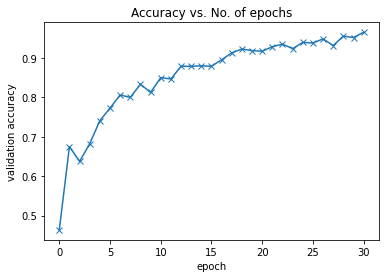

In [ ]:
plot_accuracies(history)

In [ ]:
model.eval()
dummy_input = torch.randn(32, 3, 227, 227)
input_names = [ "actual_input" ]
output_names = [ "output" ]
torch.onnx.export(model.to('cpu'), 
                  dummy_input,
                  "gender_model.onnx",
                  verbose=False,
                  input_names=input_names,
                  output_names=output_names,
                  export_params=True,
                  opset_version = 11
                  )

# NOTE : Before running the below model, we advise to clear the processor which has gender_model stored because when we run the below model without clearing the previous model, the session collapses due storage being full in colab, it might not affect you based on where you are running this but if you face a problem related to storage space running out, please follow the below steps
> ## 1) restart the runtime
> ## 2) run all the cells again until and including the cell that states "defining required functions for Convolutional models template and supporting functions" 
> 3) then skip all the remaining cell till here and run from the below cell

# Splitting data into train and test for Age model

In [ ]:
X_train, X_test, y_train, y_test = split_data(unbiased_data,classification_type = "age")

# resizing the splitted data
train_images,test_images = resize_data(X_train, X_test) 

# initilaizing the data with train, test and validation with appropriate transformations and dataloaders
train_loader,val_loader,test_loader,classes_gender,classes_age = load_data(train_images,y_train,test_images,y_test,batch_size = 32,val_size = 2000, normalize = True, augument_data = True)

# Moving data to GPU for faster processing
training_data,val_data,test_data,device = move_data_to_gpu(train_loader,val_loader,test_loader)

Train data shape (12216, 1)
Test data shape (5236, 1)
Train images shape (12216, 227, 227, 3)
Test images shape (5236, 227, 227, 3)
<class '__main__.FaceDataset'>
<class '__main__.FaceDataset'>
device being used is  cuda


# Define the CNN model for Age Classification

In [ ]:
class Age_Net(Conv_Net):
  def __init__(self, loss_func = F.cross_entropy,regularization = "L2"):
    super(Conv_Net,self).__init__()
    # self.conv1 = nn.Conv2d(3, 3, 3, padding = 'same')  #=> 32-5 +1=  28 i/p size = (32,28,28)
    self.conv1 = nn.Conv2d(3, 3, 3, padding = 1)  #=> 32-5 +1=  28 i/p size = (32,28,28)

    self.conv2 = nn.Conv2d(3, 128, 3,padding = 1) #=> 28-5 +1=  24 i/p size = (64,24,24)
    self.conv1_bn=nn.BatchNorm2d(128)
    self.pool = nn.MaxPool2d(2,2)    #=> (16,12,12)
    self.conv3 = nn.Conv2d(128, 128, 5, padding = 2) #=> 12-5 +1=  8 i/p size = (32,8,8)
    self.conv4 = nn.Conv2d(128, 256, 5, padding = 2) #=> 8-5 +1=  4 i/p size = (64,4,4)
    self.conv2_bn=nn.BatchNorm2d(256)
    self.conv5 = nn.Conv2d(256, 256, 5, padding = 2) #=> 12-5 +1=  8 i/p size = (32,8,8)
    self.conv6 = nn.Conv2d(256, 512, 5, padding = 2) #=> 8-5 +1=  4 i/p size = (64,4,4)
    self.conv3_bn=nn.BatchNorm2d(512)
    # after calculating the size based on above convolutional layers the shape here will be [batches, chanels = 16, featres = [5,5]]
    # ((W – K + 2P) / S) + 1
    self.fc1 = nn.Linear(512*28*28,120) 
    self.fc2 = nn.Linear(120,84)
    self.fc3 = nn.Linear(84,8)
    self.activation_func = F.relu;
    self.loss_func = loss_func
    self.regularization = regularization
    self.dropout = nn.Dropout(p=0.2)
  
  def forward(self,x):
    '''This function define the forward flow of the neural network.'''
    # initializing convolutional layer
    forward_flow = self.activation_func((self.conv2(x)))
    #forward_flow = self.activation_func(self.conv1_bn(self.conv2(forward_flow)))
    forward_flow = self.pool(forward_flow)
    forward_flow = self.dropout(forward_flow)
    forward_flow = self.activation_func((self.conv4(forward_flow)))
    #forward_flow = self.activation_func(self.conv2_bn(self.conv4(forward_flow)))
    forward_flow = self.pool(forward_flow)
    forward_flow = self.dropout(forward_flow)
    forward_flow = self.activation_func((self.conv6(forward_flow)))
    #forward_flow = self.activation_func(self.conv3_bn(self.conv6(forward_flow)))
    forward_flow = self.pool(forward_flow)
    forward_flow = self.dropout(forward_flow)
    # the first parameter is the batch size, which pytorch automatically configures and the flatten size is calculated again based on the formula.
    forward_flow = forward_flow.view(-1, 512*28*28)
    # fully connected network is started here
    forward_flow = self.activation_func(self.fc1(forward_flow))
    forward_flow = self.dropout(forward_flow)
    forward_flow = self.activation_func(self.fc2(forward_flow))
    forward_flow = self.dropout(forward_flow)
    forward_flow = self.fc3(forward_flow)
    return forward_flow

# Initialize the model and fit it with apprpriate hyper parameters

In [ ]:
age_model = None
age_model = to_device(Age_Net(), device)
history = [age_model.evaluate(val_data)]
history += age_model.fit(training_data, val_data, epochs = 25, learning_rate = 0.01,weight_decay = 0,moment = 0.9,classes=['0-2','4-6','8-13','15-20','25-32','38-43','48-53','60+'])

Epoch [0], val_loss: 1.8495, val_acc: 0.3051
Epoch [1], val_loss: 1.7501, val_acc: 0.3363
Epoch [2], val_loss: 1.7173, val_acc: 0.3383
Epoch [3], val_loss: 1.5938, val_acc: 0.3785
Epoch [4], val_loss: 1.5098, val_acc: 0.3988
Epoch [5], val_loss: 1.4808, val_acc: 0.4251
Epoch [6], val_loss: 1.4066, val_acc: 0.4350
Epoch [7], val_loss: 1.3682, val_acc: 0.4544
Epoch [8], val_loss: 1.3064, val_acc: 0.4821
Epoch [9], val_loss: 1.2287, val_acc: 0.5069
Epoch [10], val_loss: 1.1830, val_acc: 0.5561
Epoch [11], val_loss: 1.1249, val_acc: 0.5486
Epoch [12], val_loss: 1.0876, val_acc: 0.5660
Epoch [13], val_loss: 1.0611, val_acc: 0.5913
Epoch [14], val_loss: 1.0170, val_acc: 0.5903
Epoch [15], val_loss: 0.9551, val_acc: 0.6245
Epoch [16], val_loss: 0.9729, val_acc: 0.6225
Epoch [17], val_loss: 0.8996, val_acc: 0.6374
Epoch [18], val_loss: 0.8805, val_acc: 0.6682
Epoch [19], val_loss: 0.8180, val_acc: 0.6736
Epoch [20], val_loss: 0.7728, val_acc: 0.7083
Epoch [21], val_loss: 0.7688, val_acc: 0.710

# show test accuracy

In [ ]:
# print("The accuracy of test data is\n",f'{model.evaluate(test_data)["val_acc"]*100:3.2f}',"%\n")
# model.show_confusion_matrix(test_data = test_data,classes =['0-2','4-6','8-13','15-20','25-32','38-43','48-53','60+'] )
show_test_accuracy(age_model,test_data,classes = ['0-2','4-6','8-13','15-20','25-32','38-43','48-53','60+'])

The accuracy of test data is
 54.62 %

The test confusion matrix is..

         0-2       4-6       8-13      15-20     25-32     38-43     48-53     60+       

0-2     65.88 %   25.36 %    2.37 %    0.71 %    3.55 %    1.42 %    0.24 %    0.47 %   

4-6     13.60 %   64.32 %   10.24 %    2.24 %    7.04 %    2.08 %    0.16 %    0.32 %   

8-13     2.11 %    9.97 %   58.76 %    6.50 %   12.54 %    7.85 %    1.06 %    1.21 %   

15-20    0.18 %    2.15 %    5.02 %   35.13 %   36.92 %   17.56 %    1.79 %    1.25 %   

25-32    0.45 %    1.03 %    3.15 %    7.32 %   59.31 %   25.03 %    2.50 %    1.22 %   

38-43    0.46 %    0.68 %    1.82 %    2.62 %   25.03 %   56.43 %    5.23 %    7.74 %   

48-53    0.75 %    1.12 %    3.75 %    1.12 %   19.10 %   41.57 %   21.72 %   10.86 %   

60+      1.13 %    1.13 %    2.26 %    1.13 %    5.66 %   26.79 %   15.47 %   46.42 %   







# plot epochs vs validation accuracy for age model

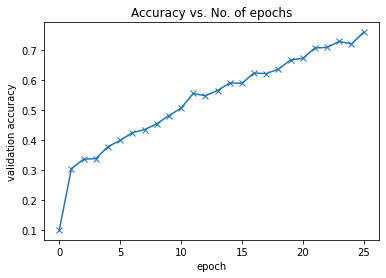

In [ ]:
plot_accuracies(history)

In [ ]:
age_model.eval()
dummy_input = torch.randn(32, 3, 227, 227)
input_names = [ "actual_input" ]
output_names = [ "output" ]
torch.onnx.export(age_model.to('cpu'), 
                  dummy_input,
                  "age_model.onnx",
                  verbose=False,
                  input_names=input_names,
                  output_names=output_names,
                  export_params=True,
                  opset_version = 11
                  )

# Contributions to the code are given below
> ## 1) Omer has started with data initialization part that includes, downloading, extracting from GitHub, filtering (removing anomalies), creating workable data from raw data. Also, Omer worked on OpenCV code for displaying live demonstration which is described in live demo notebook attached.

> ## 2) Moyeed has worked on creating the template Network and start the training process by defining all required functions. Also, Moyeed also worked on making the models compatible for use in OpenCV using ONXX.

> ## 3) Then we both together have worked on modifying the hyperparameters, adding regularization techniques and improving the accuracy by trying out different items. 